# Bài tập về nhà Decision Tree, Random Forest


- Thực hiện các yêu cầu dưới đây với tập dữ liệu Australian credit
- Down dữ liệu tại đường link dưới đây và đặt vào folder /data

  https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)
    

In [19]:
# import packages,...
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
# set random_state = 0
random_state = 0

## 1. Tìm hiểu dữ liệu

In [12]:
'''
- Tìm hiểu cấu trúc data tại trang web UCI
- Down các files, đặt trong folder data/
- Chú ý:
    - Đọc mô tả dữ liệu trong file 'australian.doc'
    - Kiểm tra DecisionTree/RandomForest của Sklearn có hỗ trợ với kiểu dữ liệu được cung cấp không
'''
data_array = np.genfromtxt('australian.dat')
data_frame = df = pd.DataFrame(data_array, columns=['A'+str(i) for i in range(1, 15)]+['Y'])
data_frame.info()

X = data_frame.drop('Y', axis=1)
y = data_frame['Y']

categorical_cols = [3, 4, 5, 11]  # A4, 5, 6, 12

# One-hot encode
encode_rules = ColumnTransformer(
    transformers=[('one_hot_encoder', OneHotEncoder(categories='auto'), categorical_cols)],
    remainder='passthrough'  # giữ nguyên các cột còn lại
)

X = encode_rules.fit_transform(X)

#Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    float64
 1   A2      690 non-null    float64
 2   A3      690 non-null    float64
 3   A4      690 non-null    float64
 4   A5      690 non-null    float64
 5   A6      690 non-null    float64
 6   A7      690 non-null    float64
 7   A8      690 non-null    float64
 8   A9      690 non-null    float64
 9   A10     690 non-null    float64
 10  A11     690 non-null    float64
 11  A12     690 non-null    float64
 12  A13     690 non-null    float64
 13  A14     690 non-null    float64
 14  Y       690 non-null    float64
dtypes: float64(15)
memory usage: 81.0 KB
(552, 38) (138, 38)


## 2. Decision Tree

### 2.1. Khảo sát các giá trị khác nhau của max_depth

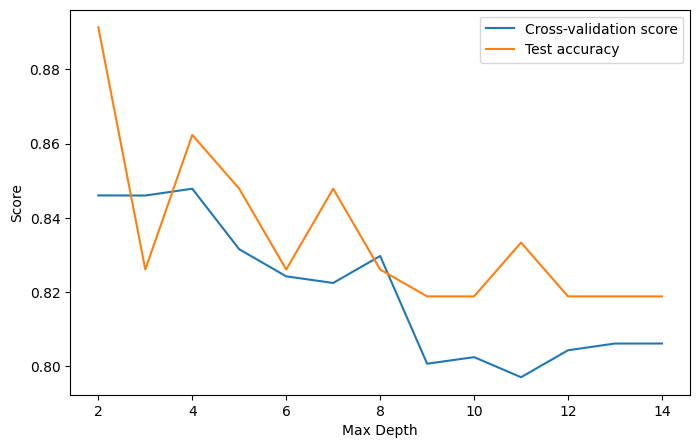

In [32]:
max_depths = np.arange(2, 15)
acc = []
cv = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
    dt.fit(X_train, y_train)

    # cross-validation (k=5)
    cv_score = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
    cv.append(np.mean(cv_score))

    # accuracy
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    acc.append(accuracy)

plt.figure(figsize=(8,5))
plt.plot(max_depths, cv,  label='Cross-validation score')
plt.plot(max_depths, acc, label='Test accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Score')
# plt.xticks(depth)
plt.legend()
# plt.grid(True)
plt.show()

### 2.2. Tìm kiếm siêu tham số

In [25]:
#code
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=random_state), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
test_acc = accuracy_score(y_test, best_model.predict(X_test))

print("Best parameters:", grid_search.best_params_)
print("Test Accuracy: ", test_acc)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 20}
Test Accuracy:  0.8623188405797102


## 3. Random Forest

### 3.1 Khảo sát các giá trị khác nhau của n_estimators

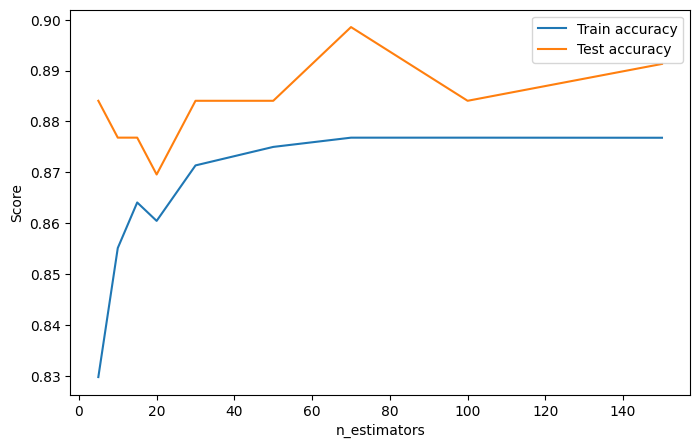

In [31]:
#code
n_estimators_range = [5, 10, 15, 20, 30, 50, 70, 100, 150]
train = []
test = []


for n_est in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_est, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)

    test.append(accuracy_score(y_test, rf.predict(X_test)))
    train.append(cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean())

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train, label='Train accuracy')
plt.plot(n_estimators_range, test, label='Test accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Score')
# plt.xticks(depth)
plt.legend()
# plt.grid(True)
plt.show()

### 3.2 Tìm kiếm siêu tham số

In [34]:
# code
param_grid = {
    'max_depth': [2,3,5,7,10, 20],
    'min_samples_leaf': [1,10,30,60],
    'max_features': [1.0,'log2','sqrt','auto'],
    'n_estimators': [1,2,3,5,10, 20, 50, 100,170]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=random_state),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
test_acc = accuracy_score(y_test, best_model.predict(X_test))

print("Best parameters:", grid_search.best_params_)
print("Test Accuracy: ", test_acc)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/u

Best parameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100}
Test Accuracy:  0.8840579710144928
